In [9]:
def get_CNN_param(cnn_day, TAIEX_df, Triple_day , hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.65) :
     
    def training (): 
        day = cnn_day
        df = TAIEX_df[::-1].reset_index(drop=True)
        ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)

        if isBias :        
            dropLabel = ['STOCK_ID','Date']
            #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
        else :
            dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']

        if hasTurning_point : 
            turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
            start = 0 
            long_list = []
            long_label = []
            hasTurningPoint= []

            for i in turning_date:
                if start == 0 :
                    start = i[0]
                    continue
                if isBias :
                    split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                else :
                    split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                long_list.extend(fn.get_series_data(split_data , day , False, isBias))
                long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
                start = i[0]
            long_list = np.array(long_list)
        else :
            if isBias : 
                df = TAIEX_bias_df[::-1].reset_index(drop=True)
                price_df = df.drop(dropLabel,axis=1)
            else :
                price_df = df.drop(dropLabel,axis=1)
            long_list = fn.get_series_data(price_df , day , False, isBias)
            long_label = ret.triple_barrier_signal[day-1:len(ret)]

        print(pd.Series(long_label).value_counts())
        balance= max(pd.Series(long_label).value_counts())/len(long_label)

    #     print(long_list , long_label)

        ## CNN Training by split data
        model, acc_list = cnn_training(long_list,long_label , day , 0.5 , 20 ,threshold)
        
        print("Param score: ", max(acc_list)/balance + max(acc_list)/2 )
        
        return max(acc_list)/balance + max(acc_list)/2
    
    Triple_down_list = [0.99,0.985,0.98,0.975,0.97,0.965,0.96]
    Triple_up_list = [1.01,1.015,1.02,1.025,1.03,1.035,1.04,1.045,1.05]
    Triple_up = Triple_up_list[math.ceil(Triple_day**0.7)] ;
    
    score_list = []
    for Triple_down in Triple_down_list :        
        score_list.append(training())
    Triple_down = Triple_down_list[score_list.index(max(score_list))]
    
    score_list = []
    for Triple_up in Triple_up_list :        
        score_list.append(training())
    Triple_up = Triple_up_list[score_list.index(max(score_list))]
    
    print("best down:" ,Triple_down)
    print("best up:" ,Triple_up)
    
    return Triple_up, Triple_down

In [2]:
def get_CNN_cluster(cnn_day, TAIEX_df, Triple_up , Triple_down, Triple_day , num_cluster, hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.45) :
    day = cnn_day
    df = TAIEX_df[::-1].reset_index(drop=True)
    ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)
    
    if isBias :        
        dropLabel = ['STOCK_ID','Date']
        #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
    else :
        dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
    
    if hasTurning_point : 
        turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
        start = 0 
        long_list = []
        long_label = []
        hasTurningPoint= []
        
        for i in turning_date:
            if start == 0 :
                start = i[0]
                continue
            if isBias :
                split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            else :
                split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            long_list.extend(fn.get_series_data(split_data , day , False, isBias))
            long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
            start = i[0]
        long_list = np.array(long_list)
    else :
        if isBias : 
            df = TAIEX_bias_df[::-1].reset_index(drop=True)
            price_df = df.drop(dropLabel,axis=1)
        else :
            price_df = df.drop(dropLabel,axis=1)
        long_list = fn.get_series_data(price_df , day , False, isBias)
        long_label = ret.triple_barrier_signal[day-1:len(ret)]
        
    print(pd.Series(long_label).value_counts())
    
#     print(long_list , long_label)
        
    ## CNN Training by split data
    model, acc_list = fn.cnn_training(long_list,long_label , day , 0.5 , 30,threshold)

    if isBias : 
        df = TAIEX_bias_df[::-1].reset_index(drop=True)
        price_df = df.drop(dropLabel,axis=1)
    else :
        price_df = df.drop(dropLabel,axis=1)
    ## 取得CNN 最後一層的output
    flatten_list = []

    ## Ini all data
    long_list = fn.get_series_data(price_df , day , False , isBias)
    long_label = ret.triple_barrier_signal[day-1:len(ret)]
    long_label = long_label[::-1].reset_index(drop=True)
        
    predict_x=model.predict(long_list) 
    cnn_predict=np.argmax(predict_x,axis=-1)
    
    for periodData in long_list :
        keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
        activations = get_activations(model, keract_inputs)
        flatten_list.append(activations['Dense'])
    long_cluster_label = pd.Series(fn.get_cluster(flatten_list, num_cluster))
    print(long_cluster_label.value_counts())
    
    if isBias : 
        return long_cluster_label , long_label
    else :
        return long_cluster_label , long_label , cnn_predict
    


In [3]:

def cnn_training(allData, allLabel, day , splitsize, epoches = 100 , threshold = 0.45) :
    score = 0
    acc_list = []
    iter = 0
    while score < threshold and iter < 5:          
        week_list = allData
        week_label = allLabel
        # 定義梯度下降批量
        batch_size = 32
        # 定義分類數量
        num_classes = 3
        # 定義訓練週期
        epochs = epoches

        # 定義圖像寬、高
        img_rows, img_cols = day, 4
        input_shape = ( img_rows, img_cols)

        # 載入 MNIST 訓練資料
        split_ratio = splitsize
        x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
        x_test = week_list[ math.ceil(len(week_list)*split_ratio*0.4) : math.ceil(len(week_list)*split_ratio) ]

        y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
        y_test = week_label[ math.ceil(len(week_list)*split_ratio*0.4)  : math.ceil(len(week_label)*split_ratio) ]

        x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

        # x_train  = torch.from_numpy(x_train)
        # x_test  = torch.from_numpy(x_test)

        # y_train = torch.from_numpy(y_train)
        # y_test = torch.from_numpy(y_test)

        input_shape = (img_rows, img_cols,1 )

        # 保留原始資料，供 cross tab function 使用
        y_test_org = y_test


        # y 值轉成 one-hot encoding
        y_train = np_utils.to_categorical(y_train, num_classes)
        y_test = np_utils.to_categorical(y_test, num_classes)

        # 建立簡單的線性執行的模型
        model = Sequential()
        # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(16, kernel_size=(3,2),
                        activation='relu',
                        input_shape=input_shape))
        # 建立池化層，池化大小=2x2，取最大值
        #model.add(BatchNormalization())
        model.add(GaussianNoise(0.3))
        # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(32,  kernel_size=(3,2), activation='relu'))
        # 建立池化層，池化大小=2x2，取最大值
        model.add(AvgPool2D(pool_size=(3, 2)))
        # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
        model.add(Dropout(0.25))
        # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
        model.add(Flatten( name ='flatten'))
        # 全連接層: 128個output
        model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
        # 使用 softmax activation function，將結果分類
        model.add(Dense(num_classes, activation='softmax' ))

        # 編譯: 選擇損失函數、優化方法及成效衡量方式
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer='adam',
                    metrics=['accuracy'])

        # 進行訓練, 訓練過程會存在 train_history 變數中
        train_history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=0,
                validation_data=(x_test, y_test))

        # 顯示損失函數、訓練成果(分數)
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score)
        print('Test accuracy:', score)
        acc_list.append(score[1])
        iter +=1
        score = score[1]
    return model, acc_list


In [4]:
import seaborn as sns
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import cnn_feature_handler as fn
from keract import get_activations, display_activations

import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D,Conv2D, MaxPooling2D , AvgPool2D,AvgPool1D ,SeparableConv2D
import tensorflow as tf 
from keras.layers import GaussianNoise , BatchNormalization
from sklearn.cluster import KMeans


from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle
import random
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, KFold
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras import metrics
from imblearn.over_sampling import RandomOverSampler

In [5]:
9## read all data
path = "./Data/" 
allData = pd.read_csv(path+'Stock.csv')
allIndex = pd.read_csv(path+'noTrend_model.csv')
columns = ['Date','Open','High','Low','Close','Volume'] 
#TAIEX_df.columns = columns
stock_list = pd.Series(allData.STOCK_ID, dtype="category").cat.categories.tolist()

index = 9
print("標的 : ",stock_list[index])
TAIEX_df = allData[allData.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
TAIEX_Index = allIndex[allIndex.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
df = TAIEX_df[::-1].reset_index(drop=True)
dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
price_df = df.drop(dropLabel,axis=1)

標的 :  2379


In [6]:
stock_list

[1216,
 1301,
 1303,
 1326,
 2002,
 2303,
 2308,
 2317,
 2330,
 2379,
 2412,
 2454,
 2603,
 2881,
 2882,
 2884,
 2885,
 2886,
 2891,
 3034,
 3711,
 5871,
 6415]

In [7]:
#long_cluster , long_label, long_out = get_CNN_cluster(20, TAIEX_df, 1.05, 0.96, 10, 3 , True, [], False,0.42)

In [8]:
short_day = 5
Triple_up,Triple_down = get_CNN_param(8, TAIEX_df, short_day , True, [], False)

-1    1884
 1    1186
 0     324
dtype: int64
Test loss: [0.8998963236808777, 0.5343811511993408]
Test accuracy: [0.8998963236808777, 0.5343811511993408]
Test loss: [0.9083754420280457, 0.5442042946815491]
Test accuracy: [0.9083754420280457, 0.5442042946815491]
Test loss: [0.9055171608924866, 0.5383104085922241]
Test accuracy: [0.9055171608924866, 0.5383104085922241]
Test loss: [0.8995985984802246, 0.5422396659851074]
Test accuracy: [0.8995985984802246, 0.5422396659851074]
Test loss: [0.9109885692596436, 0.5294695496559143]
Test accuracy: [0.9109885692596436, 0.5294695496559143]
balance score:  0.9803765266184594
-1    1678
 1    1266
 0     450
dtype: int64
Test loss: [0.9746862649917603, 0.48624753952026367]
Test accuracy: [0.9746862649917603, 0.48624753952026367]
Test loss: [0.9811578392982483, 0.4833005964756012]
Test accuracy: [0.9811578392982483, 0.4833005964756012]
Test loss: [0.9676364660263062, 0.4882121682167053]
Test accuracy: [0.9676364660263062, 0.4882121682167053]
Test lo

Test loss: [1.0987738370895386, 0.33889979124069214]
Test accuracy: [1.0987738370895386, 0.33889979124069214]
Test loss: [1.0850929021835327, 0.3958742618560791]
Test accuracy: [1.0850929021835327, 0.3958742618560791]
Test loss: [1.0828115940093994, 0.3988212049007416]
Test accuracy: [1.0828115940093994, 0.3988212049007416]
Test loss: [1.08767831325531, 0.3752455711364746]
Test accuracy: [1.08767831325531, 0.3752455711364746]
balance score:  1.0537475542083306
-1    1366
 0    1038
 1     990
dtype: int64
Test loss: [1.0997203588485718, 0.36051079630851746]
Test accuracy: [1.0997203588485718, 0.36051079630851746]
Test loss: [1.105703592300415, 0.34675833582878113]
Test accuracy: [1.105703592300415, 0.34675833582878113]
Test loss: [1.1019619703292847, 0.3998035490512848]
Test accuracy: [1.1019619703292847, 0.3998035490512848]
Test loss: [1.0894840955734253, 0.40962672233581543]
Test accuracy: [1.0894840955734253, 0.40962672233581543]
Test loss: [1.1002439260482788, 0.3634577691555023]
T

IndexError: list index out of range

In [ ]:
short_cluster, short_label ,short_out= get_CNN_cluster(8, TAIEX_df, Triple_up, Triple_down, short_day , 4 , True, [], False,0.5)

In [ ]:
long_cluster , long_label, long_out = get_CNN_cluster(16, TAIEX_df, (Triple_up*2-1), (Triple_down*2-1), short_day*2, 3 , True, [], False,0.42)

In [ ]:
bias = False
if bias : 
    allBiasData = pd.read_csv(path+'Windows5_test.csv')
    TAIEX_bias_df = allBiasData[allBiasData.STOCK_ID == stock_list[index]]
    TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date >= TAIEX_df.Date.min()]
    TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date <= TAIEX_df.Date.max()].reset_index(drop=True)

    # df = TAIEX_bias_df[::-1].reset_index(drop=True)
    # dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
    # price_df = df.drop(dropLabel,axis=1)

    long_bias_cluster , long_bias_label = get_CNN_cluster(20, TAIEX_df, 1.05, 0.97, 10, 4 , False, TAIEX_bias_df, True)
    short_bias_cluster, short_bias_label = get_CNN_cluster(8, TAIEX_df, 1.03, 0.98, 5 , 6 , False, TAIEX_bias_df, True)

In [ ]:
print (len(short_cluster), short_cluster.value_counts())
short_cluster = short_cluster[:len(long_cluster)]
short_out = short_out[:len(long_cluster)]
if bias: 
    short_bias_cluster = short_bias_cluster[:len(long_cluster)]
  

In [ ]:
TAIEX_Index

In [ ]:
# read index

Y = pd.DataFrame()
Y['long'] = long_label.reset_index(drop = True)
Y['short'] = short_label[:len(long_label)]

X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster)]
X['date'] = X.Date
X = X.drop(['Open','High','Low','Close','Volume','STOCK_ID','Date','MA5', 'MA10',  'MA20','MA60', 'MA120',
            'MA_cross_5_10','MA_cross_5_20','MA_cross_5_60','MA_cross_10_60','MA_cross_10_20','MA_cross_20_60','MA_cross_5_120'],axis = 1)
#'pre5p0.1','pre5d0.1','pre3p0.05','pre3d0.05','pre1p0.03','pre1d0.03''開盤價', '最高價', '最低價', '收盤價', '成交股數', '證券代號',  '年前高', '季前高', '漲跌',
#        '均漲天數', '均跌天數','MA60', 'RSI', 'MACD_signal','MACD','MA5', 'MA10',  'MA20', 'buy5', 'buy10',  'K', 'D',
#         '實紅棒', '紅棒天線', '實黑棒', '黑棒天線', '上避雷針', '下避雷針', '連漲跌',
#        'MACD_histogram', '日振幅', '波動率', 'MA交叉型態', 'KD交叉型態', 'KD交叉型態2',
#        'MA5 slope', 'MA10 slope', 'MA60 slope', 'buy5 slope', 'buy10 slope',
#        'MA5 acc', 'RSI5鈍化', 'D5', 'D60', 'D_upper_day', 'UD5', 'UD60',
#        'UD前高壓力', 'UD波段壓立', '均線糾結1', '均線糾結2', '三陽開泰', '突破前高', '超漲跌','MACD_histogram', '日振幅', '波動率'
# adding cluster
X['long_cluster'] = long_cluster
X['short_cluster'] = short_cluster

# X['long_out'] = long_out
# # X['short_out'] = short_out
# X['long_bias_cluster'] = long_bias_cluster
# X['short_bias_cluster'] = short_bias_cluster

if bias:
    X['long_bias_cluster'] = long_bias_cluster
    X['short_bias_cluster'] = short_bias_cluster

Y = Y[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

In [48]:
X

,MACD_cross_6,overBuyOrSold(80/20)_6,cross_6,over_3days_6,MACD_cross_9,overBuyOrSold(80/20)_9,cross_9,over_3days_9,MACD_cross_12,overBuyOrSold(80/20)_12,cross_12,over_3days_12,date,long_cluster,short_cluster
0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,20220111,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20220110,1,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20220107,1,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20220106,1,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20220105,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000218,2,1
5428,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000217,2,1
5429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20000216,2,1
5430,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20000215,1,0


## training feature : train with all feature
- serveal index and time serises price data
---
## XGBoost

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import svm

In [50]:
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


In [51]:
s_cluster = pd.Series(X.short_cluster, dtype="category").cat.categories.tolist()
for c in s_cluster : 
    print( "short cluster : ", c)
    print ( Y[X.short_cluster == c ].short.value_counts())
        
l_cluster = pd.Series(X.long_cluster, dtype="category").cat.categories.tolist()
for c in l_cluster : 
    print( "long cluster : ", c)
    print ( Y[X.long_cluster == c ].short.value_counts())

short cluster :  0
 1    711
-1    532
 0    303
Name: short, dtype: int64
short cluster :  1
 1    492
-1    486
 0    245
Name: short, dtype: int64
short cluster :  2
 1    565
-1    473
 0    254
Name: short, dtype: int64
short cluster :  3
-1    572
 1    533
 0    266
Name: short, dtype: int64
long cluster :  0
 1    866
-1    787
 0    389
Name: short, dtype: int64
long cluster :  1
 1    940
-1    727
 0    433
Name: short, dtype: int64
long cluster :  2
-1    549
 1    495
 0    246
Name: short, dtype: int64


In [52]:
Y = Y[X.short_cluster.isin([0])].reset_index(drop=True)
X = X[X.short_cluster.isin([0])].reset_index(drop=True)

In [53]:
# Y = Y[X.long_cluster.isin([0])].reset_index(drop=True)
# X = X[X.long_cluster.isin([0])].reset_index(drop=True)

label :  long
test date start form  20220111 to 20150401


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1: [0.27306273 0.28571429 0.57526882]
recall score(-1, 0, 1: [0.62711864 0.02020202 0.43319838]
training score : 0.5341959334565619
testing score : 0.39439655172413796


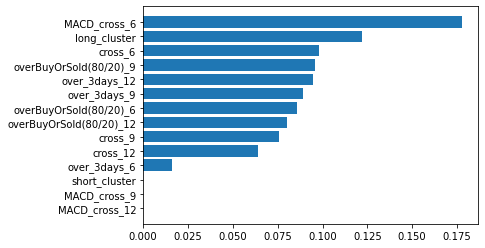

label :  short
test date start form  20220111 to 20150401


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1: [0.32824427 0.30769231 0.5875    ]
recall score(-1, 0, 1: [0.36134454 0.04761905 0.72030651]
training score : 0.5101663585951941
testing score : 0.5064655172413793


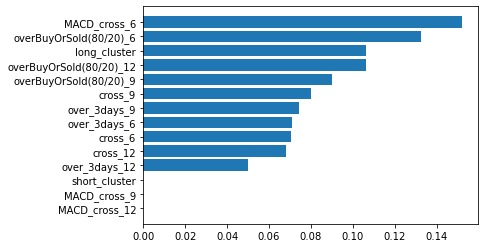

In [87]:
label_ = ['long' , 'short']
predict_ = pd.DataFrame()
predict_test = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    #ros = RandomOverSampler(random_state = 40)

    #X_train, y_train = ros.fit_resample(X_train, y_train)

    xgbc = XGBClassifier( booster='gbtree', max_depth=5,                
                  n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                  random_state=27,  tree_method='exact',
                  validate_parameters=1, verbosity=None)
    
    xgbc.fit(X_train,y_train)
    y_test_pred = xgbc.predict(X_test)
    y_train_pred = xgbc.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_pred)
    
#     print (max(xgbc.predict_proba(X_test).T[0]), min(xgbc.predict_proba(X_test).T[0]))
#     print (max(xgbc.predict_proba(X_test).T[1]), min(xgbc.predict_proba(X_test).T[1]))
#     test = pd.DataFrame(xgbc.predict_proba(X_test).T[0])
#     test['1'] = xgbc.predict_proba(X_test).T[1]
#     test['2'] = xgbc.predict_proba(X_test).T[2]
#     sns.displot(test , bins=20)
    print ( "precision(-1, 0, 1) :" ,precision )    
    print ( "recall score(-1, 0, 1) :" ,recall )
    print('training score :' , accuracy_score(y_train, y_train_pred))
    print('testing score :' , accuracy_score(y_test, y_test_pred))
    # feature important plot
    f_importances(xgbc.feature_importances_, X_train.columns)

    if isFirst :
        predict_['date'] = trainp.date
        isFirst = False
        
        predict_test['date'] = testp.date

    predict_[label] = y_train_pred
    predict_test[label] = y_test_pred

In [88]:
pd.Series(y_train_pred).value_counts()

 1    747
-1    301
 0     34
dtype: int64

In [56]:
xgb_train = y_test_pred

---
## SVM

In [80]:
label_ = ['long' , 'short']
cluster = [0,1,2]

predict_ = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    ros = RandomOverSampler(random_state = 40)

    X_train, y_train = ros.fit_resample(X_train, y_train)

    clf=svm.SVC(kernel='rbf')
    
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    y_train_pred = clf.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_pred)
    print ( "precision(-1, 0, 1:" ,precision )    
    print ( "recall score(-1, 0, 1:" ,recall )
    Y_train_pre = clf.predict(X_train)
    print('training score :' , accuracy_score(y_train, Y_train_pre))
    print('testing score :' , accuracy_score(y_test, y_test_pred))
    
    if isFirst :
        predict_['date'] = trainp.date
        isFirst = False
    predict_[label] = y_train_pred


label :  long
test date start form  20220111 to 20150401


NameError: name 'RandomOverSampler' is not defined

In [58]:
for i in range(len(xgb_train)):
    if xgb_train[i] == y_test_pred[i] :
        continue
    else :
        xgb_train[i] = 0

In [59]:
precision, recall, f1, _ = score(y_test, xgb_train)
print ( "precision(-1, 0, 1):" ,precision )
print ( "recall score(-1, 0, 1):" ,recall )

precision(-1, 0, 1): [0.31578947 0.2173913  0.58552632]
recall score(-1, 0, 1): [0.30252101 0.11904762 0.68199234]


In [60]:
pd.Series(xgb_train).value_counts()

 1    304
-1    114
 0     46
dtype: int64

In [61]:
TAIEX_Index[-100:-50]

,Open,High,Low,Close,Volume,STOCK_ID,Date,MA5,MA10,MA20,...,cross_6,over_3days_6,MACD_cross_9,overBuyOrSold(80/20)_9,cross_9,over_3days_9,MACD_cross_12,overBuyOrSold(80/20)_12,cross_12,over_3days_12
5347,523.230771,528.102566,503.743591,503.743591,3032434.0,2379,20210819,526.153845,545.348712,560.889743,...,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
5348,516.410261,532.974364,508.615389,523.230774,2552175.0,2379,20210820,525.179492,538.917944,559.769229,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5349,529.076900,542.717925,526.153823,537.846130,1603424.0,2379,20210823,526.543591,535.605121,559.038458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5350,541.743615,543.692333,533.948743,535.897461,1928806.0,2379,20210824,527.517957,532.487177,555.969229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5351,544.666692,545.641051,534.923102,535.897461,1265365.0,2379,20210825,527.323083,531.220514,554.166666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5352,536.871769,536.871769,522.256385,528.102539,1800439.0,2379,20210826,532.194873,529.174359,551.389740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5353,521.282075,529.076947,518.358997,526.153870,1537422.0,2379,20210827,532.779492,528.979492,549.051279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5354,531.025653,543.692320,528.102576,533.948730,1459895.0,2379,20210830,532.000012,529.271802,547.005124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5355,533.948707,541.743579,529.076912,539.794861,1590381.0,2379,20210831,532.779492,530.148724,544.764099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,549.538472,569.025652,542.717959,562.205139,2885272.0,2379,20210901,538.041028,532.682056,543.546152,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [89]:
# optimize by train
selected = predict_[::-1].reset_index(drop=True)

In [90]:
# optimize by test
selected = predict_test[::-1].reset_index(drop=True)
selected = selected [:math.ceil(len(selected)/2)].reset_index(drop=True)
selected

,date,long,short
0,20150401,-1,1
1,20150408,-1,-1
2,20150409,-1,-1
3,20150420,-1,-1
4,20150429,-1,1
...,...,...,...
227,20180725,1,1
228,20180801,-1,1
229,20180802,1,1
230,20180813,-1,1


In [91]:
days = [1,3,5,6,8,10,15]

table = pd.DataFrame()
p_table = []
l_table = []
d_table = []
average = []

for d in days :
    d = d-1
    if (d==0):
        profit = [0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.06,0.07,0.08,0.095] 
        loss = [0.01,0.015,0.02,0.025,0.035,0.045,0.055]
        fee = 0.0015+0.0029*0.3
    else :
        profit = [0.03,0.05,0.075,0.1,0.125,0.15] 
        loss = [0.02,0.035,0.05,0.075,0.1,0.15,0.2,0.25]
        fee = 0.003+0.0029*0.3
    
    for p in profit : 
        停利 = p
        for l in loss :
            停損 = l * -1

            進場日期 = []
            出場日期 = []
            進場價格 = []
            出場價格 = []
            獲利 = []
            for i in range(len(selected)):
                if selected.short[i] == 1 :    

                    temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
                    price = temp.Open[0]
                    進場價格.append(price)
                    進場日期.append(temp.Date[0])
                    flag = False
                    for j in range(len(temp)):
                        if temp.High[j] > price *(1.00+停利) :
                            出場價格.append(price *(1+停利-fee))
                            出場日期.append(temp.Date[j])
                            break  
                        elif temp.Low[j] < price *(1 + 停損):
                            出場價格.append(price *(1+停損-fee))
                            出場日期.append(temp.Date[j])
                            break
                        elif j > d :
                            出場價格.append(temp.Close[j]*(1-fee))
                            出場日期.append(temp.Date[j])
                            break
                    獲利.append((出場價格[-1]/進場價格[-1])-1)
            績效表 = pd.DataFrame()
            績效表['進場日期'] = 進場日期
            績效表['出場日期'] = 出場日期
            績效表['進場價格'] = 進場價格
            績效表['出場價格'] = 出場價格
            績效表['獲利'] = 獲利
            
            p_table.append(p)
            l_table.append(l)
            d_table.append(d)
            average.append(sum(績效表.獲利) / (len(績效表)*(d+1)))
            
table['p'] = p_table
table['l'] = l_table
table['d'] = d_table
table['a'] = average
        
#     elif selected.short[i] == 2 :    
        
#         temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
#         price = temp.Open[0]
#         進場價格.append(price)
#         進場日期.append(temp.Date[0])
#         flag = False
#         for j in range(len(temp)):
#             if temp.High[j] > price *(1.00+停利) :
#                 出場價格.append(price *(0.995-停利))
#                 出場日期.append(temp.Date[j])
#                 break  
#             elif temp.Low[j] < price *(1 + 停損):
#                 出場價格.append(price *(0.995 - 停損))
#                 出場日期.append(temp.Date[j])
#                 break
#             elif j == len(temp)-1 :
#                 出場價格.append(temp.Close[j]*0.995)
#                 出場日期.append(temp.Date[j])
#                 break
#         獲利.append((進場價格[-1]-出場價格[-1])/進場價格[-1])
    

# 持有水位 = []
# 總獲利 = []
# count = 0
# profit = 0
# test_time = date[date>selected.date[0] ]
# for i in range(len(test_time)):
#     profit_day = test_time[len(test_time)-1-i]
#     buy = len( 績效表[績效表.進場日期 == profit_day])
#     sell = len( 績效表[績效表.出場日期 == profit_day])
#     profit += sum(績效表[績效表.出場日期 == profit_day].獲利)
#     count += 單筆配置*(buy - sell)
#     持有水位.append(count)

# print ('統計區間 : ' + str(min(test_time)) + " ~ " + str(max(test_time)) )
# print ( '最高持有金額 : ' + str(max(持有水位)))
# print ( '總獲利 : ' + str(sum(績效表.獲利)))
# print ( '淨利率 : ' + str(round(sum((績效表.獲利)/max(持有水位)*100) , 2)) + "%")

In [92]:
table = table.sort_values(by=['a'],ascending=False).reset_index(drop = True)
table[:40]


,p,l,d,a
0,0.060,0.010,0,0.004295
1,0.040,0.010,0,0.004273
2,0.045,0.010,0,0.004259
3,0.040,0.015,0,0.004224
4,0.045,0.015,0,0.004157
5,0.060,0.015,0,0.004135
6,0.035,0.015,0,0.004047
7,0.035,0.010,0,0.004003
8,0.070,0.010,0,0.003983
9,0.060,0.020,0,0.003880


In [93]:
swing = table[table.d > 0].reset_index(drop=True)
swing

,p,l,d,a
0,0.125,0.020,2,0.002734
1,0.125,0.035,2,0.002579
2,0.125,0.075,4,0.002572
3,0.125,0.250,7,0.002556
4,0.125,0.200,7,0.002556
...,...,...,...,...
283,0.030,0.250,14,0.000604
284,0.030,0.150,14,0.000542
285,0.030,0.100,14,0.000541
286,0.030,0.035,14,0.000520


In [94]:
selected = predict_test[::-1].reset_index(drop=True)
selected = selected [math.ceil(len(selected)/2):].reset_index(drop=True)
selected

,date,long,short
0,20180816,1,1
1,20180817,-1,-1
2,20180903,-1,1
3,20180904,-1,-1
4,20180907,1,-1
...,...,...,...
227,20211210,-1,-1
228,20211220,-1,-1
229,20211224,1,1
230,20220103,-1,-1


In [95]:
def estimate_return():
    進場日期 = []
    出場日期 = []
    進場價格 = []
    出場價格 = []
    獲利 = []
    for i in range(len(selected)-1):
        if selected.short[i] == 1 :  
            temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
            price = temp.Open[0]
            進場價格.append(price)
            進場日期.append(temp.Date[0])
            flag = False
            for j in range(len(temp)):
                if temp.High[j] > price *(1.00+停利) :
                    出場價格.append(price *(return_+停利))
                    出場日期.append(temp.Date[j])
                    break  
                elif temp.Low[j] < price *(1 + 停損):
                    出場價格.append(price *(return_+停損))
                    出場日期.append(temp.Date[j])
                    break
                elif j >= d :
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    break
                elif j > len(temp)-1:
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    break
            獲利.append((出場價格[-1]/進場價格[-1])-1)
    績效表 = pd.DataFrame()
    績效表['進場日期'] = 進場日期
    績效表['出場日期'] = 出場日期
    績效表['進場價格'] = 進場價格
    績效表['出場價格'] = 出場價格
    績效表['獲利'] = 獲利

    print(績效表.獲利.std())
    print( "profit :{} , loss:{} , day :{} , out : {}".format(停利,停損, d,  sum(績效表.獲利) / len(績效表)))

In [96]:
index = 0
for i in range(2):
    if i == 0:
        停利 = table.p[index]
        停損 = table.l[index]*-1
        d=table.d[index]
    else :
        停利 = swing.p[index]
        停損 = swing.l[index]*-1
        d=swing.d[index]
        
    if (d==0):
        fee = 0.0015+0.0029*0.3
    else :
        fee = 0.003+0.0029*0.3
    return_ = 1-fee
    estimate_return()

0.01734704851669195
profit :0.06 , loss:-0.01 , day :0 , out : -0.0004357588892168283
0.03178226740248594
profit :0.125 , loss:-0.02 , day :2 , out : 0.0038833847145151885


In [97]:
selected.short.value_counts()

 1    155
-1     70
 0      7
Name: short, dtype: int64

In [78]:
(1.0038**(240/3))**5

4.559072918356123

In [79]:
(1+(0.0038*240/3))**5

3.7704046032650247

In [68]:
predict_.to_csv('Svm_train.csv',index=False, encoding='utf-8')

In [79]:
# feature important plot
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(clf.coef_[2], X_train.columns)

AttributeError: coef_ is only available when using a linear kernel

## training feature : by each cluster
- serveal index and time serises price data
---
## XGBoost

In [19]:
label_ = ['long' , 'short']
cluster_ = [0,1,2,3]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.3
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.short_cluster==cluster]
        y_train_cluster = y_train[X_train.short_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.short_cluster==cluster]
        y_test_cluster = y_test[X_test.short_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        xgbc = XGBClassifier( booster='gbtree', max_depth=5,                
                  n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                  random_state=27,  tree_method='exact',
                  validate_parameters=1, verbosity=None)

        xgbc.fit(X_train_cluster,y_train_cluster)
        y_test_predp = xgbc.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )
#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.         0.38709677 0.2875817 ]
recall score(-1, 0, 1): [0.         0.21556886 0.7394958 ]
label :  short
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.33333333 0.21568627 0.34911243]
recall score(-1, 0, 1): [0.02797203 0.09821429 0.80821918]
cluster :  1
label :  long
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.66666667 0.32352941 0.37962963]
recall score(-1, 0, 1): [0.04444444 0.34375    0.58571429]
label :  short
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.5        0.31313131 0.32894737]
recall score(-1, 0, 1): [0.04166667 0.52542373 0.34722222]
cluster :  2
label :  long
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.38666667 0.43103448 0.26181818]
recall score(-1, 0, 1): [0.12236287 0.1618123  0.73846154]
label :  short
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.34854772 0.38709677 0.30365297]
recall score(-1, 0, 1): [0.3255814  0.09230769 0.59641256]
cluster :  3
label :  long
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.25       0.40594059 0.3025641 ]
recall score(-1, 0, 1): [0.03333333 0.328      0.6344086 ]
label :  short
test date start form  20220111 to 20150515


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.2        0.43137255 0.34031414]
recall score(-1, 0, 1): [0.03846154 0.33587786 0.65656566]


In [48]:
label_ = ['long' , 'short']
cluster_ = [0,1,2,3]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.4
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.long_cluster==cluster]
        y_train_cluster = y_train[X_train.long_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.long_cluster==cluster]
        y_test_cluster = y_test[X_test.long_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        clf=svm.SVC(kernel='linear',C=2,gamma='auto')

        clf.fit(X_train_cluster,y_train_cluster)
        y_test_predp = clf.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )

#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  20220111 to 20130222
precision(-1, 0, 1): [0.51256281 0.         0.35494881]
recall score(-1, 0, 1): [0.46575342 0.         0.67973856]
label :  short
test date start form  20220111 to 20130222
precision(-1, 0, 1): [0.49350649 0.4        0.32704403]
recall score(-1, 0, 1): [0.38383838 0.05594406 0.68874172]
cluster :  1
label :  long
test date start form  20220111 to 20130222


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision(-1, 0, 1): [0.         0.29885057 0.28278689]
recall score(-1, 0, 1): [0.         0.12935323 0.90789474]
label :  short
test date start form  20220111 to 20130222
precision(-1, 0, 1): [0.         0.38912732 0.45      ]
recall score(-1, 0, 1): [0.         0.89768977 0.23275862]
cluster :  2
label :  long
test date start form  20220111 to 20130222
precision(-1, 0, 1): [0.54255319 0.         0.28892734]
recall score(-1, 0, 1): [0.34075724 0.         0.67611336]
label :  short
test date start form  20220111 to 20130222
precision(-1, 0, 1): [0.        0.        0.3041958]
recall score(-1, 0, 1): [0.         0.         0.98120301]
cluster :  3
label :  long
test date start form  20220111 to 20130222


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required.

day = 40
long_list = fn.get_series_data(price_df , day , False)
print(long_list.shape)

ret = fn.triple_barrier(TAIEX_df.Close, 1.04 ,0.97, 20)
long_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,long_label.value_counts())
long_label = long_label[::-1].reset_index(drop=True)

## CNN Training by split data

model = fn.cnn_training(long_list,long_label , day , 0.5 , 50)

## 取得CNN 最後一層的output
flatten_list = []

## Ini all data
long_list = fn.get_series_data(price_df , day , False)
long_label = ret.triple_barrier_signal[day-1:len(ret)]
long_label = long_label[::-1].reset_index(drop=True)
for periodData in long_list :
    keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['Dense'])

    day = 8
short_list = fn.get_series_data(price_df , day , True)
print(short_list.shape)

ret = fn.triple_barrier(TAIEX_df.Close, 1.01 ,0.99, 5)
short_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,short_label.value_counts())
short_label = short_label[::-1].reset_index(drop=True)

## CNN Training
model = cnn_training(short_list,short_label , day , 0.5 , 50)

## 取得CNN 最後一層的output
flatten_list = []
for periodData in short_list :
    keract_inputs = periodData.reshape(1 , short_list.shape[1], short_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['Dense'])

def get_cnn_series_data( df, period) -> list:
    list_ = []
    for i in range(len(df)-period+1):
        list_.append(df[i:i+period].values)
        
    return np.array(list_)

def cnn_training(allData, allLabel, day , splitsize, epoches = 100) :

    week_list = allData
    week_label = allLabel
    # 定義梯度下降批量
    batch_size = 32
    # 定義分類數量
    num_classes = 3
    # 定義訓練週期
    epochs = epoches

    # 定義圖像寬、高
    img_rows, img_cols = day, 17
    input_shape = ( img_rows, img_cols)

    # 載入 MNIST 訓練資料
    split_ratio = splitsize
    x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
    x_test = week_list[ : math.ceil(len(week_list)*split_ratio) ]

    y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
    y_test = week_label[ : math.ceil(len(week_label)*split_ratio) ]

    x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

    # x_train  = torch.from_numpy(x_train)
    # x_test  = torch.from_numpy(x_test)

    # y_train = torch.from_numpy(y_train)
    # y_test = torch.from_numpy(y_test)

    input_shape = (img_rows, img_cols,1 )

    # 保留原始資料，供 cross tab function 使用
    y_test_org = y_test


    # y 值轉成 one-hot encoding
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    # 建立簡單的線性執行的模型
    model = Sequential()
    # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(16, kernel_size=(3,10),
                    activation='relu',
                    input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(GaussianNoise(0.5))
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(32, (3,2), activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=(3, 5)))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
    model.add(Dropout(0.25))
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten( name ='flatten'))
    # 全連接層: 128個output
    model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
    # 使用 softmax activation function，將結果分類
    model.add(Dense(num_classes, activation='softmax' ))

    # 編譯: 選擇損失函數、優化方法及成效衡量方式
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

    # 進行訓練, 訓練過程會存在 train_history 變數中
    train_history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

    # 顯示損失函數、訓練成果(分數)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)
    print('Test accuracy:', score)
    return model

day = 10
X_cnn = get_cnn_series_data(X.drop(['date'],axis=1),day)

cnn_training(X_cnn , short_label[:len(X_cnn)], day , 0.3 , 100)


X_cnn.shape